In [39]:
from langgraph.graph import StateGraph, START, END
from typing import Literal,TypedDict,Annotated 
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
import operator
from langchain_core.messages import SystemMessage, HumanMessage

In [18]:
generator_mode = ChatGroq(model="llama-3.3-70b-versatile", temperature=1)
optimizer_mode = ChatGroq(model="llama-3.1-70b-versatile", temperature=0.5)
evaluator_mode = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

In [ ]:
class TweetState(TypedDict):
    topic:str
    tweet:str 
    evaluation:Literal['approved','rejected']
    feedback:str
    iteration:int
    max_iteration:int
    


In [20]:
class TweetEvaluation(BaseModel):
    evaluation:Literal['approved','rejected'] = Field(..., description="The evaluation result of the tweet, either 'approved' or 'rejected'.")  
    feedback:str = Field(..., description="Detailed feedback on the tweet, providing reasons for approval or rejection and suggestions for improvement if rejected.")


In [21]:
struct_eval_model = evaluator_mode.with_structured_output(TweetEvaluation)

In [22]:
def generate_tweet(state:TweetState) :
    #prompt 
    message = [
        SystemMessage(content="You are a creative and witty social media manager. Your task is to generate a tweet based on the given topic. The tweet should be engaging, concise, and relevant to the topic."),
        HumanMessage(content=f""" 
                        write a short original and hilarious tweet about {state['topic']}
                        
                        Rules: 
                        -Do not use question-answer format.
                        -max 280 characters.
                        -use observational humor and irony sarcasm or cultural refrence.
                        -Think in meme logic punchlines or relateble takes
                        -use simple day to day english.
                        This version is {state['iteration']+1}
                        
                        """)] 
    generate = generator_mode.invoke(message).content
    return {'tweet':generate}
    
    

In [32]:
def eval_tweet(state:TweetState):
    message = [
        SystemMessage(content="You are a critical and discerning social media evaluator. Your task is to evaluate the quality of a tweet based on its relevance, creativity, humor, and engagement potential. The evaluation should be concise and provide constructive feedback."),
        HumanMessage(content=f""" 
                        Evaluate the following tweet based on the topic {state['topic']}:
                        
                        Tweet: {state['tweet']}
                        
                        Evaluation Criteria:
                        -Relevance: How well does the tweet relate to the given topic?
                        -Creativity: Is the tweet original and imaginative?
                        -Humor: Does the tweet effectively use humor to engage the audience?
                        -Engagement Potential: How likely is the tweet to resonate with and engage the audience?
                        
                        
                        Auto reject if:
                        - its written in a question-answer format.
                        - it exceeds 280 characters.
                        - it reads like traditional joke setup and punchline.
                                                
                        Provide a final evaluation of either 'approved' or 'rejected' based on the criteria above, along with specific feedback for improvement if rejected.

                        """)] 
    eval_result = struct_eval_model.invoke(message)
    return {'evaluation':eval_result.evaluation, 'feedback':eval_result.feedback}

In [33]:
def optimize_tweet(state:TweetState):
    message = [
        SystemMessage(content="You are a skilled and insightful social media optimizer. Your task is to improve a given tweet based on specific feedback, enhancing its relevance, creativity, humor, and engagement potential while adhering to the original topic."),
        HumanMessage(content=f""" 
                        Optimize the following tweet based on the topic {state['topic']} and the provided feedback:
                        
                        Original Tweet: {state['tweet']}
                        
                        Feedback: {state['feedback']}
                        
                        Optimization Guidelines:
                        - Address the specific feedback provided to enhance the tweet's quality.
                        - Ensure the optimized tweet remains relevant to the original topic.
                        - Maintain or improve the humor and engagement potential of the tweet.
                        - Keep the tweet concise and within 280 characters.
                        
                        Provide an improved version of the tweet that incorporates the feedback effectively.

                        """)] 
    optimized_tweet = optimizer_mode.invoke(message).content
    iteration = state['iteration'] + 1
    return {'tweet':optimized_tweet, 'iteration': iteration}

In [34]:
def route_evaluation(state:TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_optimization'

In [35]:
graph = StateGraph(TweetState)
graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',eval_tweet)
graph.add_node('optimize',optimize_tweet)


graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate',route_evaluation, {
    'approved': END,
    'needs_optimization': 'optimize'})
graph.add_edge('optimize','evaluate')

workflow = graph.compile()

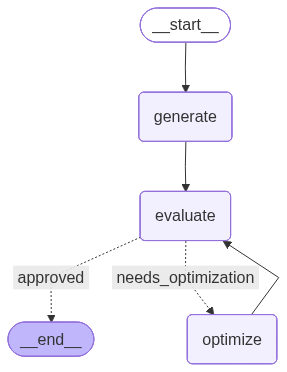

In [27]:
workflow

In [37]:
inital_state = {
    'topic': "the struggles of working from home",
    'iteration': 1,
    'max_iteration': 5
}
workflow.invoke(inital_state)

{'topic': 'the struggles of working from home',
 'tweet': '"Working from home: where pajamas are business attire and procrastination is a productivity tool" #WFHstruggles',
 'evaluation': 'approved',
 'feedback': "The tweet effectively captures the struggles of working from home, showcasing creativity and humor. The use of 'pajamas are business attire' and 'procrastination is a productivity tool' is original and engaging. The tweet is concise and within the 280-character limit, making it suitable for social media. However, consider adding a call-to-action or a question to encourage audience participation and increase engagement potential.",
 'iteration': 1,
 'max_iteration': 5}